# Library Tools and Packages


In [175]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# General Analysis

In [176]:
data = pd.read_csv("riceClassification.csv")
data

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18180,18181,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,18182,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,18183,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,18184,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


In [177]:
data = data.drop(labels=['id'],axis=1)

In [178]:
data.shape

(18185, 11)

# Data Splitting


In [179]:
Y  = data['Class']
X = data.drop('Class',axis=1)

In [180]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [181]:
train_set = pd.concat([X_train,Y_train],axis=1)
test_set = pd.concat([X_test,Y_test],axis=1)

# Outlier Analysis 

In [182]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [183]:
X_train_copy = X_train.copy()
X = StandardScaler().fit_transform(X_train_copy.values)

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_

In [184]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('The number of clusters in dataset is:', n_clusters_)

The number of clusters in dataset is: 1


In [185]:
pd.Series(labels).value_counts()

 0    14542
-1        6
Name: count, dtype: int64

In [186]:
outlier_count = (labels == -1).sum()
total_points = len(labels)
outlier_percentage = (outlier_count / total_points) * 100
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

Percentage of outliers: 0.04%


# Correlation Analysis 

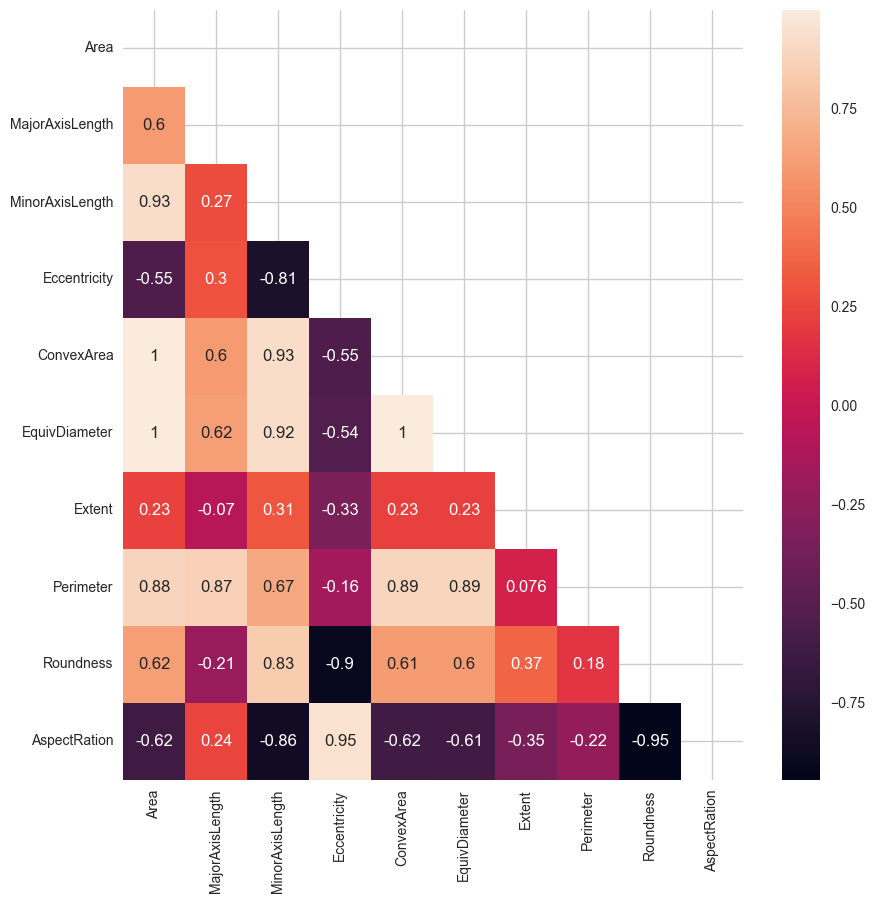

In [187]:
%matplotlib inline
mask = np.triu(np.ones_like(X_train.corr())) 
plt.figure(figsize=(10,10))
sns.heatmap(X_train.corr(),annot=True,mask=mask)
plt.show()

In [188]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]

print(vif_data)

           feature            VIF
0             Area   56606.747799
1  MajorAxisLength   48006.743054
2  MinorAxisLength   30779.928698
3     Eccentricity   15063.660109
4       ConvexArea   44101.243665
5    EquivDiameter  199503.608971
6           Extent      41.308519
7        Perimeter   25025.516633
8        Roundness    8561.919556
9     AspectRation    3542.206442


# Variable Importance 

## Using RF 

In [189]:
rfc = RandomForestClassifier(random_state=10 ,n_estimators=10)
rfc.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=10, random_state=10)

In [190]:
y_pred = rfc.predict(X_test)

Accuracy = accuracy_score(Y_test, y_pred)
Accuracy

0.9895518284300248

In [191]:
y_pred_tr = rfc.predict(X_train)

Accuracy_tr = accuracy_score(Y_train, y_pred_tr)
Accuracy_tr

0.999312620291449

### Above part is to check accuracy while changing n_estimators

In [192]:
clf = RandomForestClassifier(random_state=10,n_estimators=100)
clf.fit(X_train, Y_train)

RandomForestClassifier(random_state=10)

In [193]:
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

MinorAxisLength    0.293332
Eccentricity       0.236372
AspectRation       0.179265
EquivDiameter      0.108761
Roundness          0.097708
Area               0.040770
ConvexArea         0.026768
MajorAxisLength    0.006996
Perimeter          0.006469
Extent             0.003559
dtype: float64

In [194]:
feature_scores_df = feature_scores.reset_index()
feature_scores_df.columns = ['Feature', 'Score']

C:\Users\Ganeshi\AppData\Local\Temp\ipykernel_23580\3876392432.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Feature', data=feature_scores_df, palette=colors, ax=plt.gca())
C:\Users\Ganeshi\AppData\Local\Temp\ipykernel_23580\3876392432.py:8: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x='Score', y='Feature', data=feature_scores_df, palette=colors, ax=plt.gca())


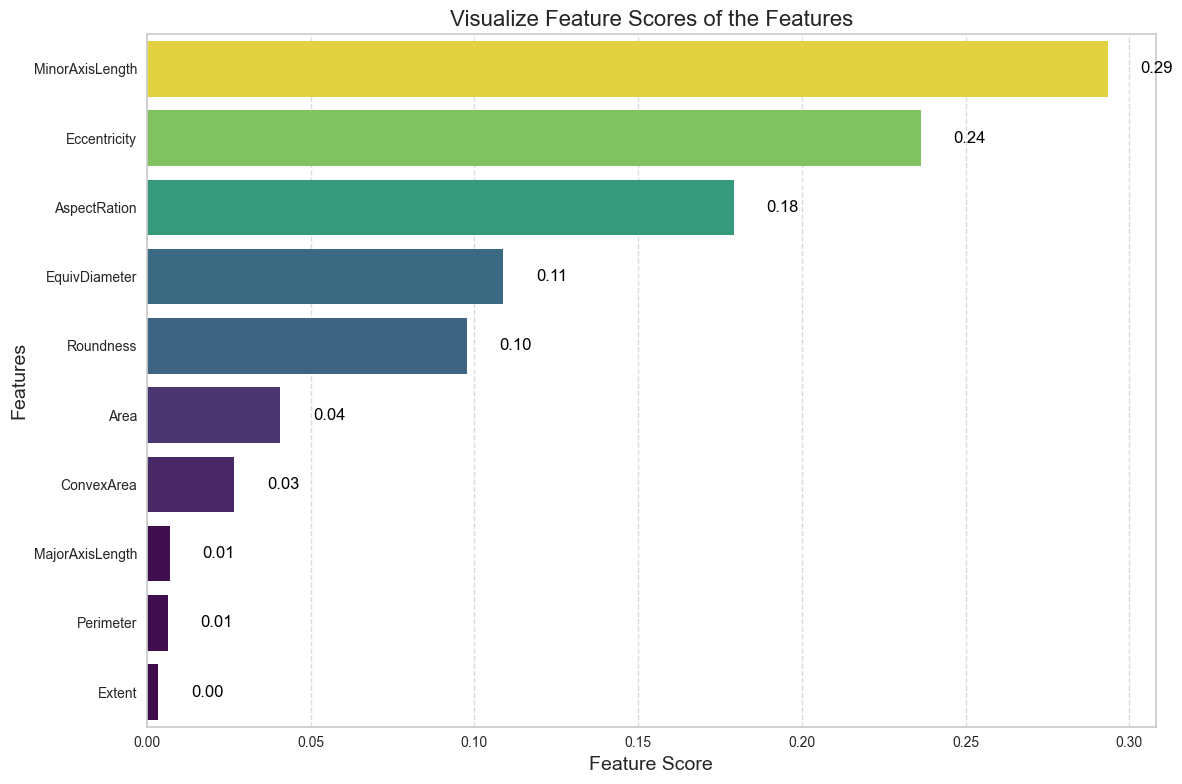

In [195]:
norm_scores = (feature_scores_df['Score'] - feature_scores_df['Score'].min()) / (feature_scores_df['Score'].max() - feature_scores_df['Score'].min())

colors = sns.color_palette("viridis", as_cmap=True)(norm_scores)


plt.figure(figsize=(12, 8))

sns.barplot(x='Score', y='Feature', data=feature_scores_df, palette=colors, ax=plt.gca())

for index, value in enumerate(feature_scores_df['Score']):
    plt.text(value + 0.01, index, f'{value:.2f}', color='black', va='center')


plt.title("Visualize Feature Scores of the Features", fontsize=16)
plt.xlabel("Feature Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

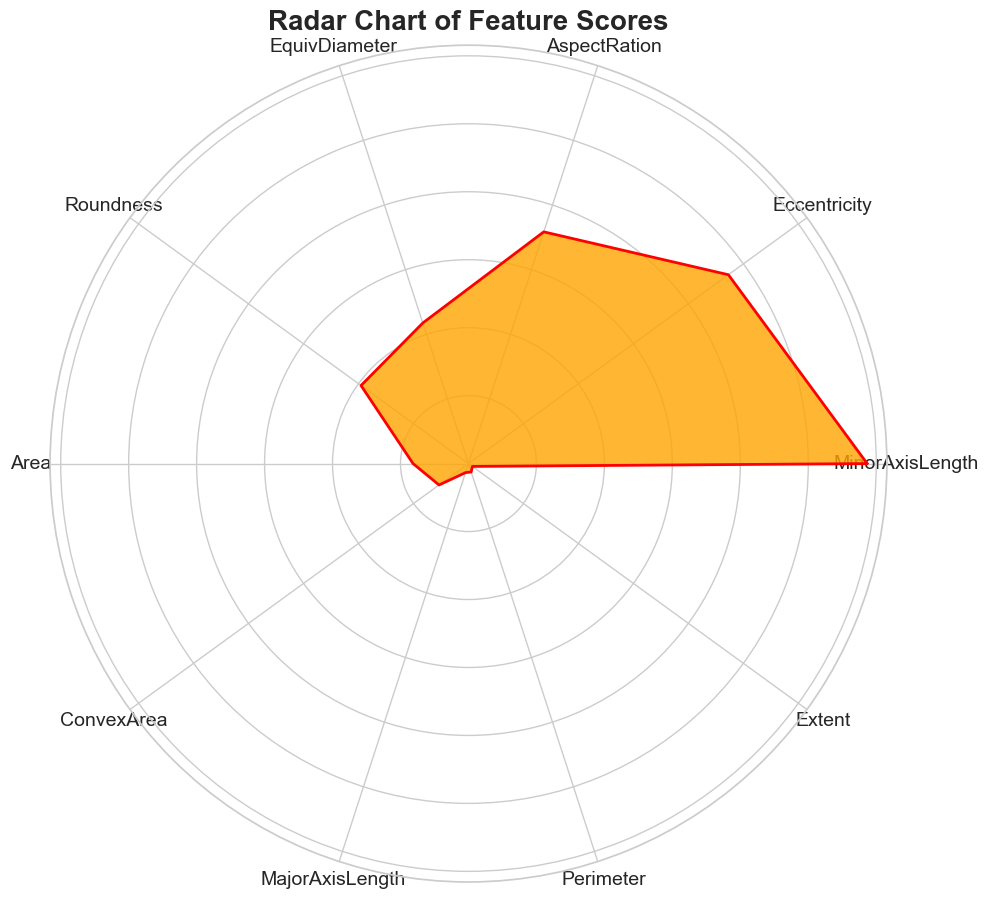

In [196]:
num_vars = len(feature_scores_df['Feature'])

# Create a 2D array to hold the values
values = feature_scores_df['Score'].values
values = np.concatenate((values, [values[0]]))  # complete the loop
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Create the radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Fill the area with a solid color
ax.fill(angles, values, color='orange', alpha=0.8)  # Change to 'orange' or any desired color
ax.plot(angles, values, color='red', linewidth=2)  # Outline color

# Set the labels
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(feature_scores_df['Feature'], fontsize=14)

# Set title
plt.title("Radar Chart of Feature Scores", fontsize=20, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

In [197]:
threshold = 0.05
selected_features = feature_scores_df[feature_scores_df['Score'] > threshold]['Feature'].values
selected_features

array(['MinorAxisLength', 'Eccentricity', 'AspectRation', 'EquivDiameter',
       'Roundness'], dtype=object)

In [198]:
X_selected = X_train[selected_features]
X_selected 

,MinorAxisLength,Eccentricity,AspectRation,EquivDiameter,Roundness
723,52.681930,0.919969,2.551072,83.186880,0.701640
1274,53.696529,0.926368,2.655191,87.038930,0.724436
10672,47.186511,0.956836,3.440813,86.510705,0.575230
1954,52.658820,0.930318,2.726630,85.831020,0.675926
3239,50.283875,0.935041,2.820567,83.796874,0.686714
...,...,...,...,...,...
9372,51.421649,0.950955,3.232804,91.196495,0.602574
7291,51.986057,0.945194,3.062713,90.107983,0.639184
17728,73.691878,0.908573,2.393918,113.574600,0.733910
7293,48.463357,0.945203,3.062948,84.492924,0.649608


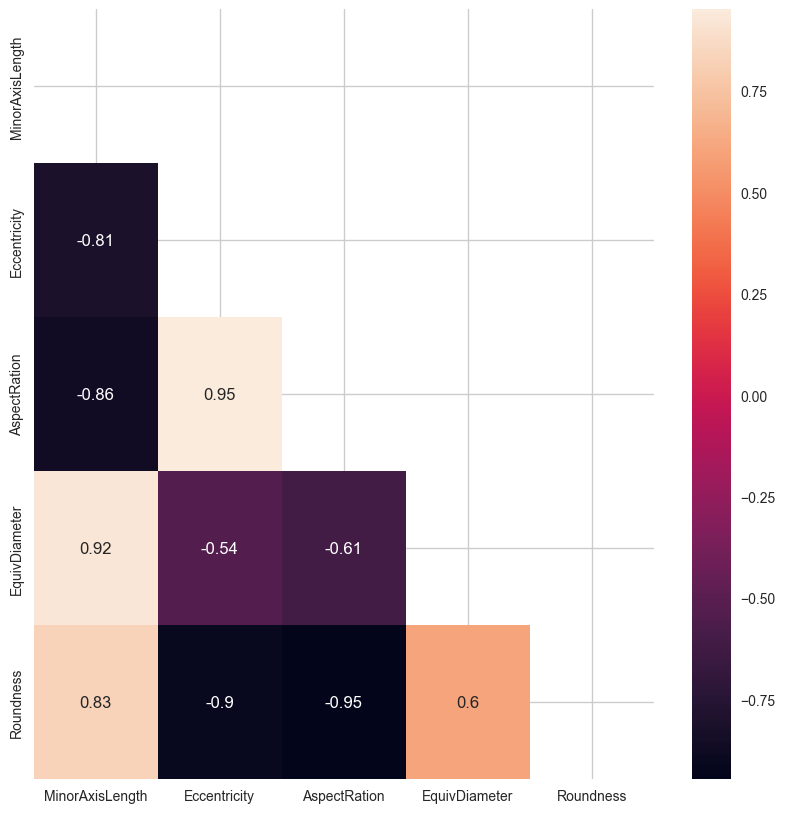

In [199]:
%matplotlib inline
mask = np.triu(np.ones_like(X_selected .corr())) 
plt.figure(figsize=(10,10))
sns.heatmap(X_selected .corr(),annot=True,mask=mask)
plt.show()

In [200]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_selected.columns

vif_data["VIF"] = [variance_inflation_factor(X_selected.values,i)
                          for i in range(len(X_selected.columns))]

print(vif_data)

           feature          VIF
0  MinorAxisLength  4226.796845
1     Eccentricity  2952.277240
2     AspectRation  1230.972639
3    EquivDiameter  4594.981646
4        Roundness   976.108881


# RFE 


In [201]:
from sklearn.feature_selection import RFE

In [202]:
estimator = RandomForestClassifier(random_state=10 ,n_estimators=10)

In [203]:
n_features_to_select = 5 
rfe = RFE(estimator=estimator,n_features_to_select=n_features_to_select)
rfe.fit(X_train,Y_train)

RFE(estimator=RandomForestClassifier(n_estimators=10, random_state=10),
    n_features_to_select=5)

In [204]:
selected_features = X_train.columns[rfe.support_]

In [205]:
print("Selected Features:", selected_features)

Selected Features: Index(['MinorAxisLength', 'Eccentricity', 'EquivDiameter', 'Roundness',
       'AspectRation'],
      dtype='object')


In [206]:
X_selected_rfe = X_train[selected_features]
X_selected_rfe

,MinorAxisLength,Eccentricity,EquivDiameter,Roundness,AspectRation
723,52.681930,0.919969,83.186880,0.701640,2.551072
1274,53.696529,0.926368,87.038930,0.724436,2.655191
10672,47.186511,0.956836,86.510705,0.575230,3.440813
1954,52.658820,0.930318,85.831020,0.675926,2.726630
3239,50.283875,0.935041,83.796874,0.686714,2.820567
...,...,...,...,...,...
9372,51.421649,0.950955,91.196495,0.602574,3.232804
7291,51.986057,0.945194,90.107983,0.639184,3.062713
17728,73.691878,0.908573,113.574600,0.733910,2.393918
7293,48.463357,0.945203,84.492924,0.649608,3.062948


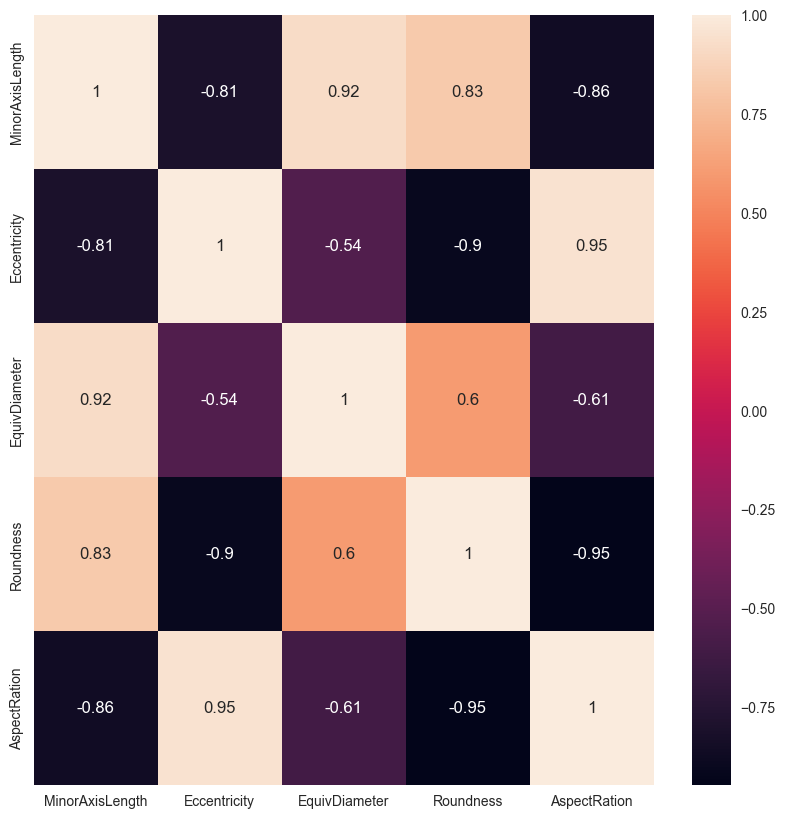

In [207]:
%matplotlib inline
mask = np.triu(np.ones_like(X_selected_rfe.corr())) 
plt.figure(figsize=(10,10))
sns.heatmap(X_selected_rfe.corr(),annot=True)
plt.show()

In [208]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_selected_rfe.columns

vif_data["VIF"] = [variance_inflation_factor(X_selected_rfe.values,i)
                          for i in range(len(X_selected_rfe.columns))]

print(vif_data)

           feature          VIF
0  MinorAxisLength  4226.796845
1     Eccentricity  2952.277240
2    EquivDiameter  4594.981646
3        Roundness   976.108881
4     AspectRation  1230.972639


# Standardizing 

In [209]:
predictors = data[X_selected_rfe.columns]
response = data['Class']

In [210]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)
data_en_s = pd.DataFrame(predictors_scaled, columns=predictors.columns, index=data.index)
data_en_s['Class'] = response 

data_en_s

,MinorAxisLength,Eccentricity,EquivDiameter,Roundness,AspectRation,Class
0,0.417927,-6.393938,-1.830049,0.839588,-2.663800,1
1,-0.835611,-6.209583,-3.398143,1.837215,-2.635418,1
2,-0.771700,-6.024520,-3.213879,2.383587,-2.605950,1
3,-0.783130,-5.781578,-3.188141,2.409877,-2.565690,1
4,-0.341288,-5.433479,-2.580390,2.477331,-2.504645,1
...,...,...,...,...,...,...
18180,-0.872502,0.778548,-0.788051,-0.661944,0.720875,0
18181,-0.165603,0.784700,0.417903,-0.990018,0.730936,0
18182,-0.685768,0.796550,-0.414880,-0.373899,0.750451,0
18183,-0.828242,0.818359,-0.708755,-1.081165,0.786835,0


In [211]:
Ys  = data_en_s['Class']
Xs = data_en_s.drop('Class',axis=1)

In [212]:
Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(Xs, Ys, test_size=0.2, random_state=10)
train_set_s = pd.concat([Xs_train,Ys_train],axis=1)
test_set_s = pd.concat([Xs_test,Ys_test],axis=1)

In [213]:
train_set_s

,MinorAxisLength,Eccentricity,EquivDiameter,Roundness,AspectRation,Class
723,-0.708245,0.149219,-1.104997,-0.094471,-0.110410,1
1274,-0.607404,0.358509,-0.716136,0.244214,0.129040,1
10672,-1.254435,1.355043,-0.769459,-1.972539,1.935797,1
1954,-0.710542,0.487729,-0.838073,-0.476506,0.293334,1
3239,-0.946588,0.642207,-1.043418,-0.316228,0.509369,1
...,...,...,...,...,...,...
9372,-0.833504,1.162700,-0.296433,-1.566292,1.457423,1
7291,-0.777408,0.974287,-0.406317,-1.022374,1.066252,1
17728,1.379933,-0.223488,1.962618,0.384964,-0.471830,0
7293,-1.127529,0.974569,-0.973153,-0.867504,1.066791,1


# Clustering

In [214]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [215]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=10)
    kmeans.fit(Xs_train)
    wcss.append(kmeans.inertia_)

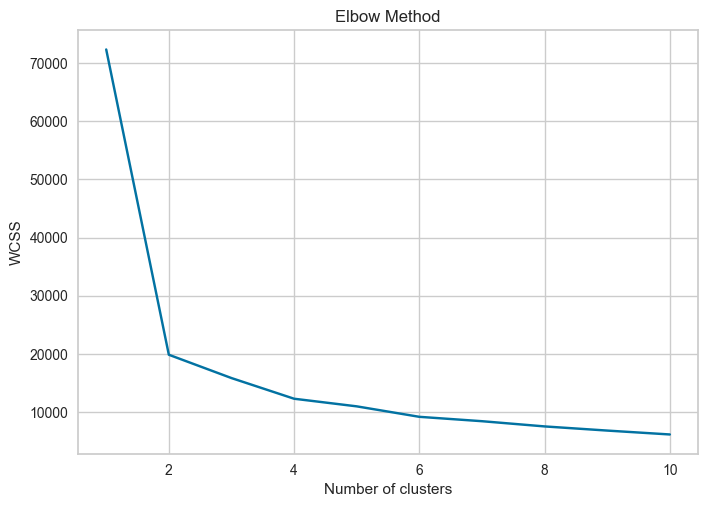

In [216]:
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [217]:
noise = np.random.normal(0, 0.5, Xs_train.shape)  
Xs_noisy = Xs_train + noise

kmeans2 = KMeans(n_clusters=2, random_state=582, n_init=25, algorithm='lloyd')
kmeans2.fit(Xs_noisy)

zero = []
one = []
for i in kmeans2.labels_:
    if i == 0:
        zero.append(i)
    else:
        one.append(i)


print('\n',
      "Cluster centers:", '\n',
      "Cluster 0 :", kmeans2.cluster_centers_[0],'\n',
       "Cluster 1 :", kmeans2.cluster_centers_[1], '\n','\n',
        "Clustering vector:" ,'\n', kmeans2.labels_, '\n','\n',
         "Total Within Cluster Sum of Squares : ", '\n',
         kmeans2.inertia_ , '\n',
          "Observation numbers :", '\n',
          "Cluster 0 :", len(zero), '\n',
          "Cluster 1 :", len(one))


 Cluster centers: 
 Cluster 0 : [ 0.96815767 -0.90470795  0.81272014  0.94728759 -0.94544103] 
 Cluster 1 : [-0.83780563  0.79183381 -0.7075012  -0.80590704  0.82104269] 
 
 Clustering vector: 
 [1 1 1 ... 0 1 0] 
 
 Total Within Cluster Sum of Squares :  
 37718.252607867165 
 Observation numbers : 
 Cluster 0 : 6695 
 Cluster 1 : 7853


C:\Users\Ganeshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


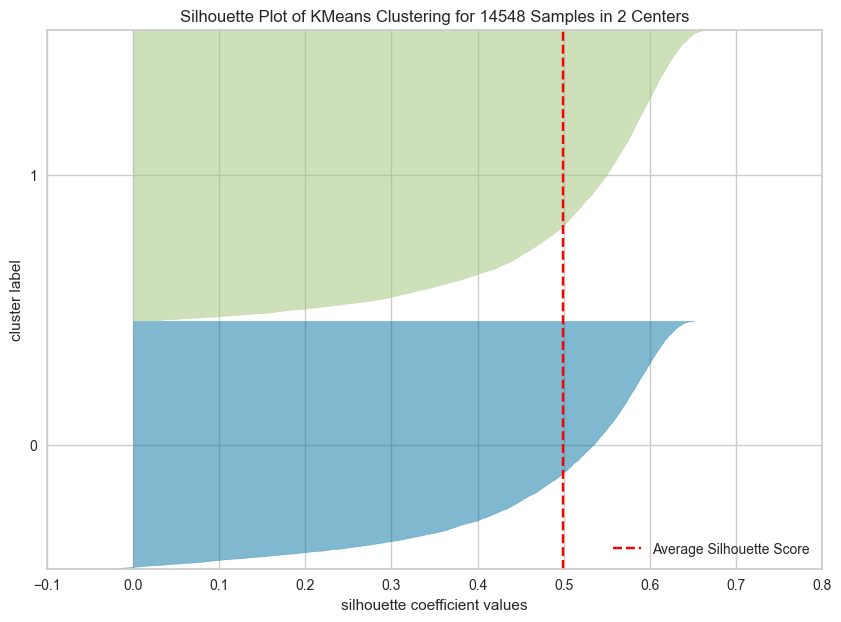

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 14548 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, n_init=25,
                                      random_state=582))

In [218]:
from yellowbrick.cluster import silhouette_visualizer
plt.figure(figsize=(10,7))
silhouette_visualizer(kmeans2, Xs_noisy, colors='yellowbrick')

# Logistic Regression 

In [219]:
logi_model = LogisticRegression(penalty='l2',solver='liblinear',random_state = 10,multi_class='ovr')

In [220]:
param_grid_logi = {'solver': ['lbfgs', 'newton-cg','sag','saga'],'penalty':['None','l2','l1']}

In [221]:
grid_search_logi = GridSearchCV(estimator=logi_model, param_grid=param_grid_logi, cv=5, scoring='accuracy')

In [222]:
grid_search_logi.fit(Xs_train,Ys_train)

C:\Users\Ganeshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Ganeshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Ganeshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Ganeshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Ganeshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='ovr', random_state=10,
                                          solver='liblinear'),
             param_grid={'penalty': ['None', 'l2', 'l1'],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             scoring='accuracy')

In [223]:
best_params_logi = grid_search_logi.best_params_
best_params_logi

{'penalty': 'l1', 'solver': 'saga'}

In [224]:
best_logi_model = grid_search_logi.best_estimator_
best_logi_model

LogisticRegression(multi_class='ovr', penalty='l1', random_state=10,
                   solver='saga')

In [225]:
y_pred_logi = best_logi_model.predict(Xs_test)

Accuracy_logi= accuracy_score(Ys_test, y_pred_logi)
Accuracy_logi

0.9892768765466043

In [226]:
y_train_pred_logi = best_logi_model.predict(Xs_train)
Accuracy_train_logi = accuracy_score(Ys_train, y_train_pred_logi)
print("Training Set Accuracy:", Accuracy_train_logi)

Training Set Accuracy: 0.9894830904591696


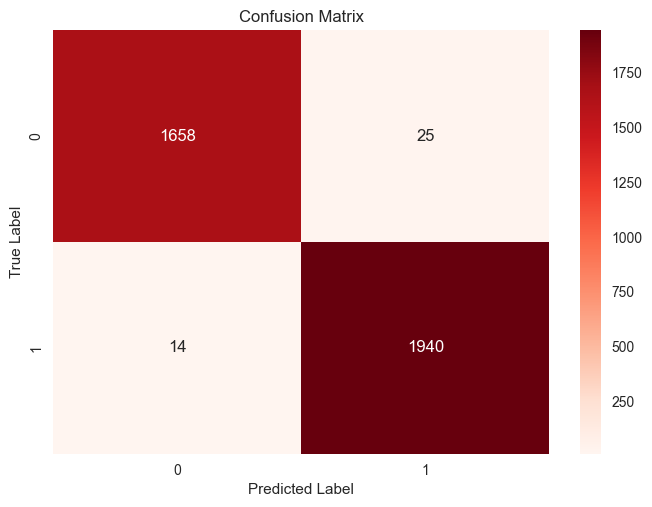

In [227]:
class_labels = ['0', '1']
conf_matrix_logi = confusion_matrix(Ys_test, y_pred_logi)
sns.heatmap(conf_matrix_logi, annot=True, fmt='d', cmap='Reds', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [228]:
print(f"Classification Report for Training Set:\n{classification_report(Ys_train, y_train_pred_logi,digits=4)}\n\nClassification Report for Test Set:\n{classification_report(Ys_test, y_pred_logi,digits=4)}")

Classification Report for Training Set:
              precision    recall  f1-score   support

           0     0.9910    0.9854    0.9882      6517
           1     0.9882    0.9928    0.9905      8031

    accuracy                         0.9895     14548
   macro avg     0.9896    0.9891    0.9894     14548
weighted avg     0.9895    0.9895    0.9895     14548


Classification Report for Test Set:
              precision    recall  f1-score   support

           0     0.9916    0.9851    0.9884      1683
           1     0.9873    0.9928    0.9900      1954

    accuracy                         0.9893      3637
   macro avg     0.9895    0.9890    0.9892      3637
weighted avg     0.9893    0.9893    0.9893      3637



# XG Boost 

In [229]:
xgb_model = xgb.XGBClassifier(random_state=10,booster='dart',alpha=5,gamma=1,sample_type='uniform',normalize_type='forest',rate_drop=0.1)

In [230]:
param_grid_xgb = {'learning_rate': [0.05, 0.1] ,'max_depth': [2, 3],'n_estimators': [50, 100],'lambda':[2.5,3],'subsample': [0.7, 0.8],'colsample_bytree': [0.7, 0.8]}

In [231]:
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='neg_log_loss',n_jobs=-1)

In [232]:
grid_search_xgb.fit(Xs_train ,Ys_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(alpha=5, base_score=None, booster='dart',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=1, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     normalize_type='forest',
                                     num_parallel_tree=None, predictor=None,
                                     random_state=10, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8], 'lambda': [2.5, 3],
                         'learning_rate': [0.05, 0.1], 'max_depth': [2, 3],
                         'n_estimators': [50, 100], 'subsample': [0.7, 0.8]},
             scoring='neg_log_loss')

In [233]:
best_params_xgb = grid_search_xgb.best_params_
best_params_xgb

{'colsample_bytree': 0.8,
 'lambda': 2.5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.8}

In [234]:
best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_model

XGBClassifier(alpha=5, base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', lambda=2.5,
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, normalize_type='forest', num_parallel_tree=1,
              predictor='auto', ...)

In [235]:
y_pred_xgb = best_xgb_model.predict(Xs_test)

Accuracy_xgb = accuracy_score(Ys_test, y_pred_xgb)
Accuracy_xgb

0.9895518284300248

In [236]:
y_train_pred_xgb = best_xgb_model.predict(Xs_train)
Accuracy_train_xgb = accuracy_score(Ys_train, y_train_pred_xgb)
print("Training Set Accuracy:", Accuracy_train_xgb) 

Training Set Accuracy: 0.9909265878471267


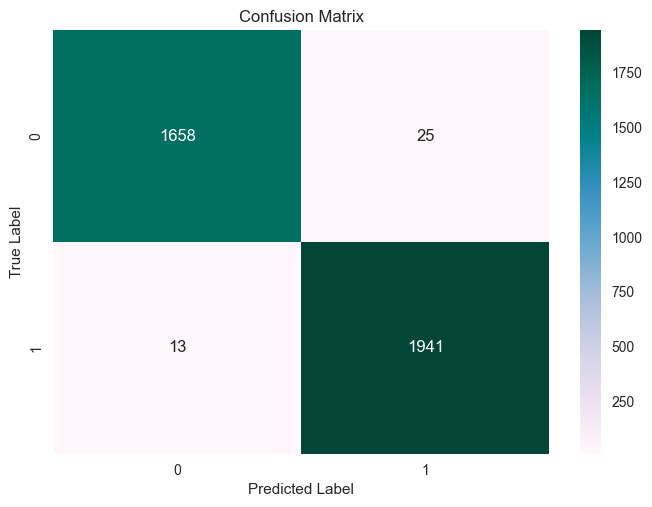

In [237]:
class_labels = ['0', '1']
conf_matrix_logi = confusion_matrix(Ys_test, y_pred_xgb)
sns.heatmap(conf_matrix_logi, annot=True, fmt='d', cmap='PuBuGn', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [238]:
print(f"Classification Report for Training Set:\n{classification_report(Ys_train, y_train_pred_xgb,digits=4)}\n\nClassification Report for Test Set:\n{classification_report(Ys_test, y_pred_xgb,digits=4)}")

Classification Report for Training Set:
              precision    recall  f1-score   support

           0     0.9929    0.9868    0.9898      6517
           1     0.9893    0.9943    0.9918      8031

    accuracy                         0.9909     14548
   macro avg     0.9911    0.9905    0.9908     14548
weighted avg     0.9909    0.9909    0.9909     14548


Classification Report for Test Set:
              precision    recall  f1-score   support

           0     0.9922    0.9851    0.9887      1683
           1     0.9873    0.9933    0.9903      1954

    accuracy                         0.9896      3637
   macro avg     0.9898    0.9892    0.9895      3637
weighted avg     0.9896    0.9896    0.9895      3637



# Random Forest

In [239]:
rf_model = RandomForestClassifier(random_state=10)

In [240]:
param_grid_rf = {'criterion': ['gini','entropy'] ,'n_estimators': [25,35,45],'max_depth': [2,3,4]} 

In [241]:
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy')

In [242]:
grid_search_rf.fit(Xs_train ,Ys_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4], 'n_estimators': [25, 35, 45]},
             scoring='accuracy')

In [243]:
best_params_rf = grid_search_rf.best_params_
best_params_rf

{'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 45}

In [244]:
best_rf_model = grid_search_rf.best_estimator_
best_rf_model

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=45,
                       random_state=10)

In [245]:
y_pred_rf = best_rf_model.predict(Xs_test)
Accuracy_rf = accuracy_score(Ys_test, y_pred_rf)
Accuracy_rf

0.9887269727797635

In [246]:
y_train_pred_rf = best_rf_model.predict(Xs_train)
Accuracy_train_rf = accuracy_score(Ys_train, y_train_pred_rf)
print("Training Set Accuracy:", Accuracy_train_rf)

Training Set Accuracy: 0.9898955182843002


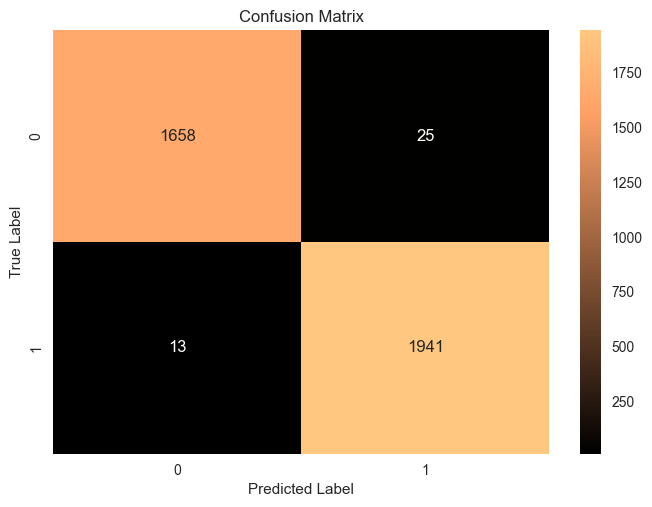

In [247]:
class_labels = ['0', '1']
conf_matrix_rf = confusion_matrix(Ys_test, y_pred_rf)
sns.heatmap(conf_matrix_logi, annot=True, fmt='d', cmap='copper', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [248]:
print(f"Classification Report for Training Set:\n{classification_report(Ys_train, y_train_pred_rf,digits=4)}\n\nClassification Report for Test Set:\n{classification_report(Ys_test, y_pred_rf,digits=4)}")

Classification Report for Training Set:
              precision    recall  f1-score   support

           0     0.9912    0.9862    0.9887      6517
           1     0.9888    0.9929    0.9909      8031

    accuracy                         0.9899     14548
   macro avg     0.9900    0.9895    0.9898     14548
weighted avg     0.9899    0.9899    0.9899     14548


Classification Report for Test Set:
              precision    recall  f1-score   support

           0     0.9922    0.9834    0.9878      1683
           1     0.9858    0.9933    0.9895      1954

    accuracy                         0.9887      3637
   macro avg     0.9890    0.9884    0.9887      3637
weighted avg     0.9888    0.9887    0.9887      3637



# SVM

In [249]:
param_grid_svm_K = {'C': [1,1.5,2,2.5,3,3.5],'gamma':['scale','auto',0.01,0.1],'decision_function_shape':['ovo','ovr']} 

## Polynomial Kernal 

In [250]:
svm_polyK_model = SVC(random_state=10,probability=True,kernel='poly')

In [251]:
grid_search_svm_polyK = GridSearchCV(estimator=svm_polyK_model , param_grid=param_grid_svm_K, scoring='accuracy', cv=3, n_jobs=-1)

In [252]:
grid_search_svm_polyK.fit(Xs_train,Ys_train)

GridSearchCV(cv=3,
             estimator=SVC(kernel='poly', probability=True, random_state=10),
             n_jobs=-1,
             param_grid={'C': [1, 1.5, 2, 2.5, 3, 3.5],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto', 0.01, 0.1]},
             scoring='accuracy')

In [253]:
best_svm_polyK_model = grid_search_svm_polyK.best_estimator_
best_svm_polyK_model

SVC(C=3.5, decision_function_shape='ovo', gamma='auto', kernel='poly',
    probability=True, random_state=10)

In [254]:
y_pred_svm_polyK = best_svm_polyK_model.predict(Xs_test)
Accuracy_svm_polyK= accuracy_score(Ys_test, y_pred_svm_polyK)
Accuracy_svm_polyK

0.9813032719274127

In [255]:
y_pred_svm_polyK_train = best_svm_polyK_model.predict(Xs_train)
Accuracy_svm_polyK_train = accuracy_score(Ys_train, y_pred_svm_polyK_train)
Accuracy_svm_polyK_train

0.9836403629364862

## RBF Kernal 

In [256]:
svm_rbfK_model = SVC(random_state=10,probability=True,kernel='rbf')

In [257]:
grid_search_svm_rbfK = GridSearchCV(estimator=svm_rbfK_model , param_grid=param_grid_svm_K, scoring='accuracy', cv=5, n_jobs=-1)

In [258]:
grid_search_svm_rbfK.fit(Xs_train,Ys_train)

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=10), n_jobs=-1,
             param_grid={'C': [1, 1.5, 2, 2.5, 3, 3.5],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto', 0.01, 0.1]},
             scoring='accuracy')

In [259]:
best_svm_rbfK_model = grid_search_svm_rbfK.best_estimator_
best_svm_rbfK_model

SVC(C=3, decision_function_shape='ovo', probability=True, random_state=10)

In [260]:
y_pred_svm_rbfK = best_svm_rbfK_model.predict(Xs_test)
Accuracy_svm_rbfK= accuracy_score(Ys_test, y_pred_svm_rbfK)
Accuracy_svm_rbfK

0.9901017321968656

In [261]:
y_pred_svm_rbfK_train = best_svm_rbfK_model.predict(Xs_train)
Accuracy_svm_rbfK_train = accuracy_score(Ys_train, y_pred_svm_rbfK_train)
Accuracy_svm_rbfK_train

0.9902392081385758

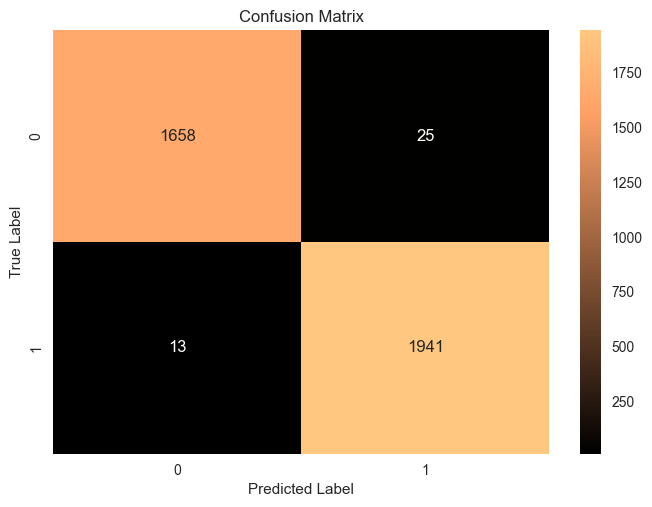

In [262]:
class_labels = ['0', '1']
conf_matrix_rf = confusion_matrix(Ys_test, y_pred_svm_rbfK)
sns.heatmap(conf_matrix_logi, annot=True, fmt='d', cmap='copper', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [263]:
print(f"Classification Report for Training Set:\n{classification_report(Ys_train, y_pred_svm_rbfK_train,digits=4)}\n\nClassification Report for Test Set:\n{classification_report(Ys_test, y_pred_svm_rbfK,digits=4)}")

Classification Report for Training Set:
              precision    recall  f1-score   support

           0     0.9933    0.9848    0.9891      6517
           1     0.9878    0.9946    0.9912      8031

    accuracy                         0.9902     14548
   macro avg     0.9906    0.9897    0.9901     14548
weighted avg     0.9903    0.9902    0.9902     14548


Classification Report for Test Set:
              precision    recall  f1-score   support

           0     0.9940    0.9846    0.9893      1683
           1     0.9868    0.9949    0.9908      1954

    accuracy                         0.9901      3637
   macro avg     0.9904    0.9897    0.9900      3637
weighted avg     0.9901    0.9901    0.9901      3637



# SIgmoid Kernal

In [264]:
svm_sigK_model = SVC(random_state=10,probability=True,kernel='sigmoid')

In [265]:
grid_search_svm_sigK = GridSearchCV(estimator=svm_sigK_model , param_grid=param_grid_svm_K, scoring='accuracy', cv=5, n_jobs=-1)
                                    

In [266]:
grid_search_svm_sigK.fit(Xs_train,Ys_train)

GridSearchCV(cv=5,
             estimator=SVC(kernel='sigmoid', probability=True, random_state=10),
             n_jobs=-1,
             param_grid={'C': [1, 1.5, 2, 2.5, 3, 3.5],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto', 0.01, 0.1]},
             scoring='accuracy')

In [267]:
best_svm_sigK_model = grid_search_svm_sigK.best_estimator_
best_svm_sigK_model

SVC(C=3.5, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid',
    probability=True, random_state=10)

In [268]:
y_pred_svm_sigK = best_svm_sigK_model.predict(Xs_test)
Accuracy_svm_sigK= accuracy_score(Ys_test, y_pred_svm_sigK)
Accuracy_svm_sigK

0.9862524058289799

## Linear Kernal 

In [269]:
svm_lK_model = SVC(random_state=10,probability=True,kernel='linear')

In [270]:
grid_search_svm_lK = GridSearchCV(estimator=svm_lK_model , param_grid=param_grid_svm_K, scoring='accuracy', cv=5, n_jobs=-1)

In [271]:
grid_search_svm_lK.fit(Xs_train,Ys_train)

GridSearchCV(cv=5,
             estimator=SVC(kernel='linear', probability=True, random_state=10),
             n_jobs=-1,
             param_grid={'C': [1, 1.5, 2, 2.5, 3, 3.5],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto', 0.01, 0.1]},
             scoring='accuracy')

In [272]:
best_svm_lK_model = grid_search_svm_lK.best_estimator_
best_svm_lK_model

SVC(C=1, decision_function_shape='ovo', kernel='linear', probability=True,
    random_state=10)

In [273]:
y_pred_svm_lK = best_svm_lK_model.predict(Xs_test)
Accuracy_svm_lK= accuracy_score(Ys_test, y_pred_svm_lK)
Accuracy_svm_lK

0.9881770690129228

In [274]:
y_pred_svm_lK_train = best_svm_lK_model.predict(Xs_train)
Accuracy_svm_lK_train = accuracy_score(Ys_train, y_pred_svm_lK_train)
Accuracy_svm_lK_train

0.9890706626340391

C:\Users\Ganeshi\AppData\Local\Temp\ipykernel_23580\3122063439.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kernal', y='Score', data=result_svm, ax=ax , palette='Paired')
C:\Users\Ganeshi\AppData\Local\Temp\ipykernel_23580\3122063439.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=result_svm.Kernal, rotation=45)


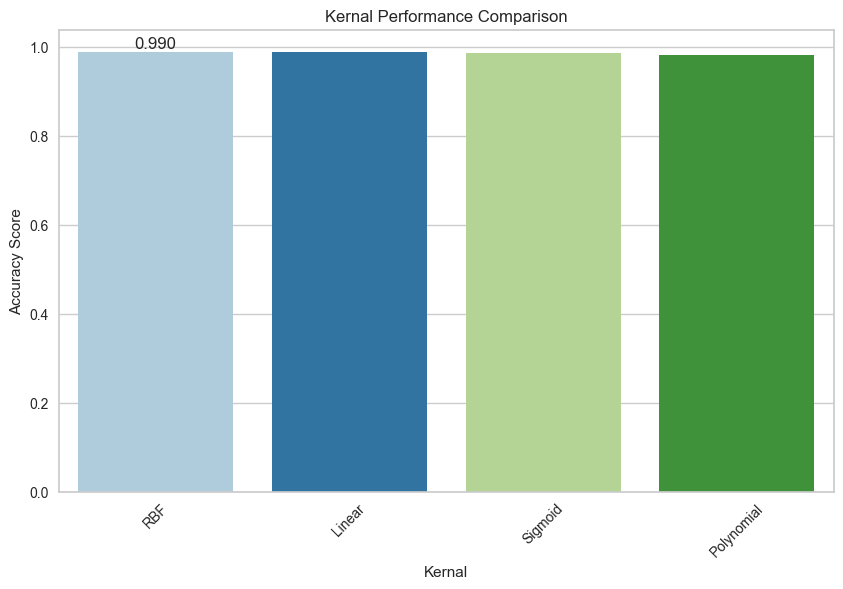

In [275]:
result_svm = pd.DataFrame({
    'Kernal': ['Linear', 'Polynomial','RBF','Sigmoid'],
    'Score': [Accuracy_svm_lK, Accuracy_svm_polyK,Accuracy_svm_rbfK,Accuracy_svm_sigK]
})
result_svm

result_svm.sort_values(by='Score', ascending=False, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(x='Kernal', y='Score', data=result_svm, ax=ax , palette='Paired')
ax.bar_label(ax.containers[0], fmt='%.3f')
ax.set_xticklabels(labels=result_svm.Kernal, rotation=45)
plt.title('Kernal Performance Comparison')
plt.ylabel('Accuracy Score')
plt.show()

# Model Performance Comparisson

In [276]:
result = pd.DataFrame({
    'Algorithm': ['RandomForestClassifier', 'LogisticRegression','XGBoostClassifier','SVM'],
    'Score': [Accuracy_rf,Accuracy_logi,Accuracy_xgb,Accuracy_svm_rbfK]
})
result

,Algorithm,Score
0,RandomForestClassifier,0.988727
1,LogisticRegression,0.989277
2,XGBoostClassifier,0.989552
3,SVM,0.990102


C:\Users\Ganeshi\AppData\Local\Temp\ipykernel_23580\2672220342.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Score', data=result, ax=ax, palette='magma')
C:\Users\Ganeshi\AppData\Local\Temp\ipykernel_23580\2672220342.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=result.Algorithm, rotation=45)


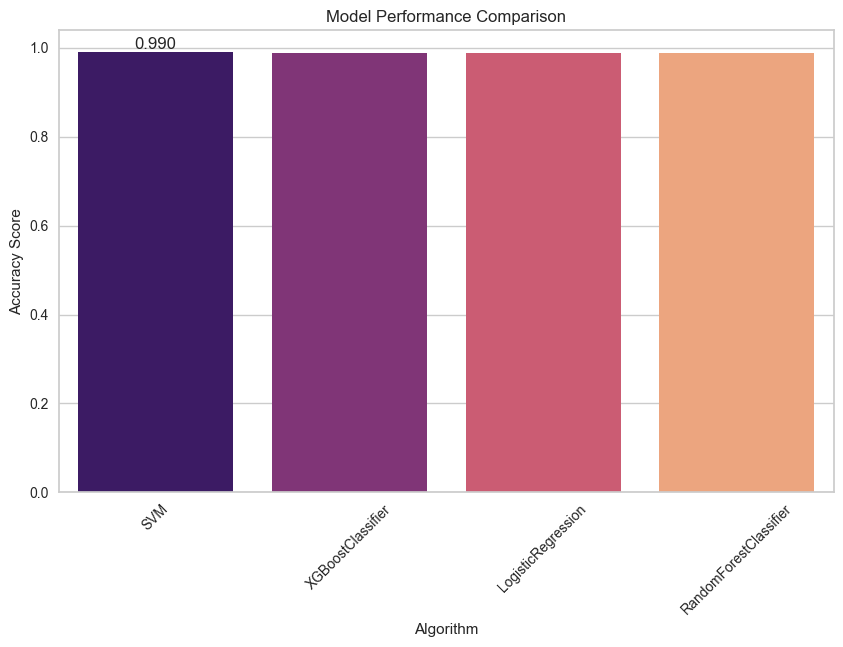

In [277]:
result.sort_values(by='Score', ascending=False, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(x='Algorithm', y='Score', data=result, ax=ax, palette='magma')
ax.bar_label(ax.containers[0], fmt='%.3f')
ax.set_xticklabels(labels=result.Algorithm, rotation=45)
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy Score')
plt.show()

# Partial Dependence Plots

In [278]:
from sklearn.inspection import PartialDependenceDisplay

In [168]:
features_to_plot = ['MinorAxisLength', 'Eccentricity', 'EquivDiameter', 'Roundness','AspectRation']

ValueError: Feature 'Area' not in feature_names

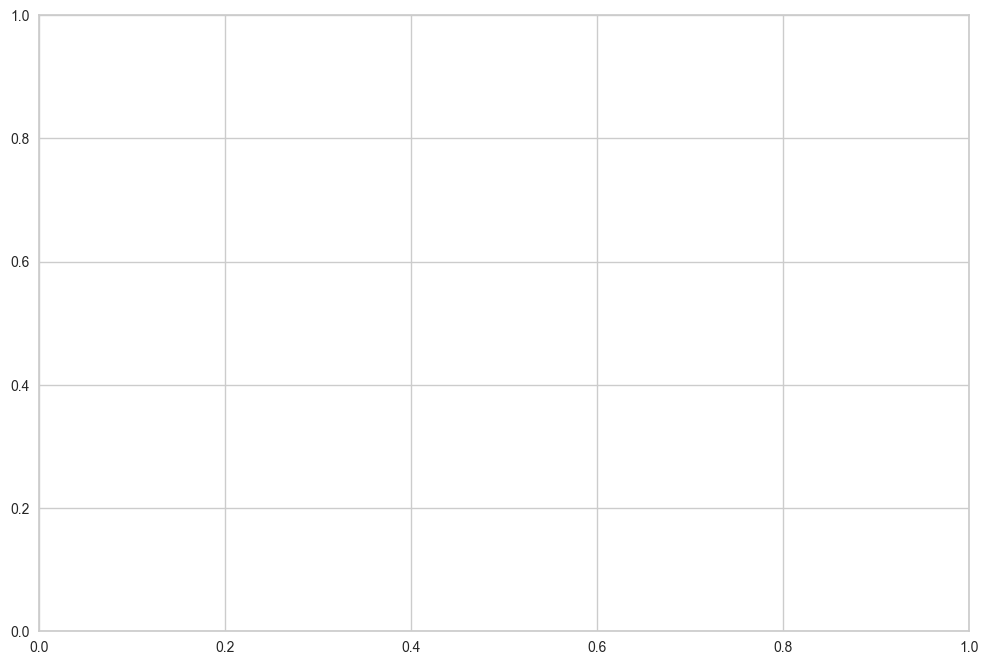

In [169]:
fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(
    best_svm_rbfK_model,  
    Xs_train,            
    features=features_to_plot,
    ax=ax,
    grid_resolution=50
)

plt.title('Partial Dependence Plots')
plt.show()

# SHAP Values

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
# Use a reduced sample of the training data as the background for faster SHAP computation
background_sample = shap.sample(X_selected_rfe,10)  # Adjust sample size as needed

# Initialize KernelExplainer with the trained SVM model and the reduced background sample
explainer = shap.KernelExplainer(best_svm_rbfK_model.predict, background_sample)

# Compute SHAP values for the full feature set in `X_selected_rfe`
shap_values = explainer.shap_values(X_selected_rfe)

# Plot SHAP summary plot for the selected features
shap.summary_plot(shap_values, X_selected_rfe, feature_names=features_to_plot, plot_type="bar")

# Plot individual SHAP dependence plots for each feature in `features_to_plot`
for feature in features_to_plot:
    shap.dependence_plot(feature, shap_values, X_selected_rfe)